In [38]:
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import librosa
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
from skimage.transform import resize

device="cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [39]:
data_df=pd.read_csv("C:/Users/nihal/Downloads/archive (2)/files_paths.csv")
print(data_df['Class'].unique())
print()
print(len(data_df['Class'].unique())) 
data_df.head()

['Mohammed_Aluhaidan' 'Yasser_Aldossary' 'Maher_Almuaiqly'
 'Nasser_Alqutami' 'AbdulBari_Althubaity' 'Bander_Balilah'
 'Ali_Alhothaify' 'Saud_Alshuraim' 'Mohammed_Ayoub' 'AbdulRahman_Alsudais'
 'Saad_Alghamdi' 'Abdullah_Albuaijan']

12


,FilePath,Class
0,./Dataset/Mohammed_Aluhaidan/lohaidan_171.wav,Mohammed_Aluhaidan
1,./Dataset/Mohammed_Aluhaidan/lohaidan_159.wav,Mohammed_Aluhaidan
2,./Dataset/Mohammed_Aluhaidan/lohaidan_401.wav,Mohammed_Aluhaidan
3,./Dataset/Mohammed_Aluhaidan/lohaidan_367.wav,Mohammed_Aluhaidan
4,./Dataset/Mohammed_Aluhaidan/lohaidan_373.wav,Mohammed_Aluhaidan


In [40]:
data_df["FilePath"]='C:/Users/nihal/Downloads/archive (2)/Dataset'+data_df["FilePath"].str[1:]
data_df.head()

,FilePath,Class
0,C:/Users/nihal/Downloads/archive (2)/Dataset/D...,Mohammed_Aluhaidan
1,C:/Users/nihal/Downloads/archive (2)/Dataset/D...,Mohammed_Aluhaidan
2,C:/Users/nihal/Downloads/archive (2)/Dataset/D...,Mohammed_Aluhaidan
3,C:/Users/nihal/Downloads/archive (2)/Dataset/D...,Mohammed_Aluhaidan
4,C:/Users/nihal/Downloads/archive (2)/Dataset/D...,Mohammed_Aluhaidan


In [41]:
data_df["FilePath"].iloc[2]

'C:/Users/nihal/Downloads/archive (2)/Dataset/Dataset/Mohammed_Aluhaidan/lohaidan_401.wav'

In [42]:
print("Data Shape:",data_df.shape)
print("class distribution:\n",data_df['Class'].value_counts())

Data Shape: (6687, 2)
class distribution:
 Class
Saud_Alshuraim          696
Saad_Alghamdi           688
AbdulRahman_Alsudais    648
Yasser_Aldossary        576
Ali_Alhothaify          576
Bander_Balilah          576
Maher_Almuaiqly         576
Abdullah_Albuaijan      504
Mohammed_Ayoub          480
Nasser_Alqutami         456
AbdulBari_Althubaity    456
Mohammed_Aluhaidan      455
Name: count, dtype: int64


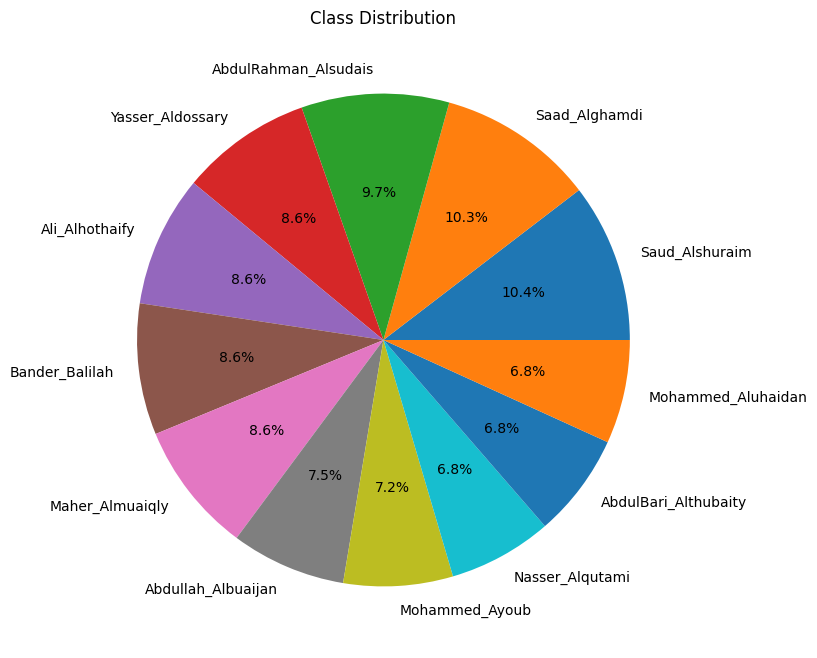

In [43]:
plt.figure(figsize=(8,8))
plt.pie(data_df['Class'].value_counts(),labels=data_df['Class'].value_counts().index,autopct='%1.1f%%')
plt.title("Class Distribution")
plt.show()

In [44]:
label_encoder=LabelEncoder()
data_df['Class']=label_encoder.fit_transform(data_df['Class'])

train=data_df.sample(frac=0.7,random_state=7)
test=data_df.drop(train.index)

val=test.sample(frac=0.5,random_state=7)
test=test.drop(val.index)

print("Train shape:",train.shape)
print("Val shape:",val.shape)
print("Test shape:",test.shape)
print(data_df.head)

Train shape: (4681, 2)
Val shape: (1003, 2)
Test shape: (1003, 2)
<bound method NDFrame.head of                                                FilePath  Class
0     C:/Users/nihal/Downloads/archive (2)/Dataset/D...      6
1     C:/Users/nihal/Downloads/archive (2)/Dataset/D...      6
2     C:/Users/nihal/Downloads/archive (2)/Dataset/D...      6
3     C:/Users/nihal/Downloads/archive (2)/Dataset/D...      6
4     C:/Users/nihal/Downloads/archive (2)/Dataset/D...      6
...                                                 ...    ...
6682  C:/Users/nihal/Downloads/archive (2)/Dataset/D...      2
6683  C:/Users/nihal/Downloads/archive (2)/Dataset/D...      2
6684  C:/Users/nihal/Downloads/archive (2)/Dataset/D...      2
6685  C:/Users/nihal/Downloads/archive (2)/Dataset/D...      2
6686  C:/Users/nihal/Downloads/archive (2)/Dataset/D...      2

[6687 rows x 2 columns]>


In [45]:
class CustomAudioDataset(Dataset):
    def __init__(self,dataframe):
        self.dataframe=dataframe
        self.labels=torch.Tensor(list(dataframe["Class"])).type(torch.LongTensor).to(device)
        self.audios=[torch.Tensor(self.get_spectrogram(path)).type(torch.FloatTensor) for path in dataframe['FilePath']]
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self,idx):
        img_path = self.dataframe['FilePath'].iloc[idx]
        label=torch.Tensor(self.labels[idx]).to(device)
        audio=self.audios[idx].unsqueeze(0).to(device)
        return audio,label
    def get_spectrogram(self,file_path):
        sr=22050
        duration=5

        img_height=128
        img_width=256

        signal, sr=librosa.load(file_path,sr=sr,duration=duration)
        spec=librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=2048,hop_length=512,n_mels=128)
        spec_db=librosa.power_to_db(spec,ref=np.max)

        spec_resized=librosa.util.fix_length(spec_db,size=(duration*sr)//512+1)
        spec_resized=resize(spec_resized,(img_height,img_width),anti_aliasing=True)
        return spec_resized

In [46]:
train_dataset=CustomAudioDataset(dataframe=train)  
val_dataset=CustomAudioDataset(dataframe=val)
test_dataset=CustomAudioDataset(dataframe=test)

In [47]:
lr=0.001
Batch_size=16
EPOCHS=25

In [48]:
train_loader=DataLoader(dataset=train_dataset,batch_size=Batch_size,shuffle=True)
val_loader=DataLoader(dataset=val_dataset,batch_size=Batch_size,shuffle=False)
test_loader=DataLoader(dataset=test_dataset,batch_size=Batch_size,shuffle=False)

In [49]:
class AudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1)
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1)
        self.conv3=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.relu=nn.ReLU()

        self.flatten=nn.Flatten()
        self.linear1=nn.Linear(64*16*32,4096)
        self.linear2=nn.Linear(4096,1024)
        self.linear3=nn.Linear(1024,512)
        self.output=nn.Linear(512,len(data_df['Class'].unique()))
        
        self.dropout=nn.Dropout(0.5)
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.pool(x)
        x=self.conv2(x)
        x=self.pool(x)
        x=self.conv3(x)
        x=self.pool(x)  
        x=self.relu(x)

        x=x.view(x.size(0),-1)

        x=self.flatten(x)
        x=self.linear1(x)
        x=self.dropout(x)   

        x=self.linear2(x)
        x=self.dropout(x)

        x=self.linear3(x)
        x=self.dropout(x)

        x=self.output(x)
        return x

In [50]:
model=AudioClassifier().to(device)
print(model)

AudioClassifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=32768, out_features=4096, bias=True)
  (linear2): Linear(in_features=4096, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=12, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [51]:
from torchsummary import summary
summary(model,(1,128,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 256]             160
         MaxPool2d-2          [-1, 16, 64, 128]               0
            Conv2d-3          [-1, 32, 64, 128]           4,640
         MaxPool2d-4           [-1, 32, 32, 64]               0
            Conv2d-5           [-1, 64, 32, 64]          18,496
         MaxPool2d-6           [-1, 64, 16, 32]               0
              ReLU-7           [-1, 64, 16, 32]               0
           Flatten-8                [-1, 32768]               0
            Linear-9                 [-1, 4096]     134,221,824
          Dropout-10                 [-1, 4096]               0
           Linear-11                 [-1, 1024]       4,195,328
          Dropout-12                 [-1, 1024]               0
           Linear-13                  [-1, 512]         524,800
          Dropout-14                  [

In [52]:
criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=lr)

In [54]:
total_loss_train_plot=[]
total_loss_val_plot=[]
total_acc_train_plot=[]
total_acc_val_plot=[]

start_time=time.time()
for epoch in range(EPOCHS):
    total_acc_train=0
    total_loss_train=0
    total_loss_val=0
    total_acc_val=0

    for input,labels in train_loader:
        outputs=model(input)
        train_loss=criterion(outputs,labels)
        total_loss_train+=train_loss.item()
        train_loss.backward()

        train_acc=(torch.argmax(outputs,axis=1)==labels).sum().item()
        total_acc_train+=train_acc

        optimizer.step()
        optimizer.zero_grad()


    with torch.no_grad():
        for input,labels in val_loader:
            outputs=model(input)
            val_loss=criterion(outputs,labels)
            total_loss_val+=val_loss.item()

            val_acc=(torch.argmax(outputs,axis=1)==labels).sum().item()
            total_acc_val+=val_acc 

    total_loss_train_plot.append(total_loss_train/len(train_loader))
    total_loss_val_plot.append(total_loss_val/len(val_loader))
    total_acc_train_plot.append(total_acc_train/len(train_dataset))
    total_acc_val_plot.append(total_acc_val/len(val_dataset))

    print(f"Epoch: {epoch+1} | Train Loss: {total_loss_train/len(train_loader):.4f} | Train Acc: {total_acc_train/len(train_dataset):.4f} | Val Loss: {total_loss_val/len(val_loader):.4f} | Val Acc: {total_acc_val/len(val_dataset):.4f}")
    print("="*30)
print(f"Total time taken: {time.time()-start_time:.2f} seconds")

Epoch: 1 | Train Loss: 1.3428 | Train Acc: 0.5533 | Val Loss: 1.4788 | Val Acc: 0.5025
Epoch: 2 | Train Loss: 1.3288 | Train Acc: 0.5627 | Val Loss: 1.4196 | Val Acc: 0.5334
Epoch: 3 | Train Loss: 1.2883 | Train Acc: 0.5685 | Val Loss: 1.3289 | Val Acc: 0.5494
Epoch: 4 | Train Loss: 1.2933 | Train Acc: 0.5740 | Val Loss: 1.2728 | Val Acc: 0.5743
Epoch: 5 | Train Loss: 1.2864 | Train Acc: 0.5715 | Val Loss: 1.4137 | Val Acc: 0.5284
Epoch: 6 | Train Loss: 1.3399 | Train Acc: 0.5604 | Val Loss: 1.3781 | Val Acc: 0.5364
Epoch: 7 | Train Loss: 1.5545 | Train Acc: 0.5193 | Val Loss: 1.8521 | Val Acc: 0.4247
Epoch: 8 | Train Loss: 2.3569 | Train Acc: 0.2525 | Val Loss: 2.4959 | Val Acc: 0.1117
Epoch: 9 | Train Loss: 2.5022 | Train Acc: 0.1102 | Val Loss: 2.4771 | Val Acc: 0.1167
Epoch: 10 | Train Loss: 2.4010 | Train Acc: 0.1686 | Val Loss: 2.3125 | Val Acc: 0.2223
Epoch: 11 | Train Loss: 2.2386 | Train Acc: 0.2284 | Val Loss: 1.8301 | Val Acc: 0.3719
Epoch: 12 | Train Loss: 2.0463 | Train Ac

In [55]:
with torch.no_grad():
    total_acc_test=0
    for input,labels in test_loader:
        outputs=model(input)
        test_acc=(torch.argmax(outputs,axis=1)==labels).sum().item()
        total_acc_test+=test_acc
    print(f"Test Acc: {total_acc_test/len(test_dataset):.4f}")

Test Acc: 0.5294


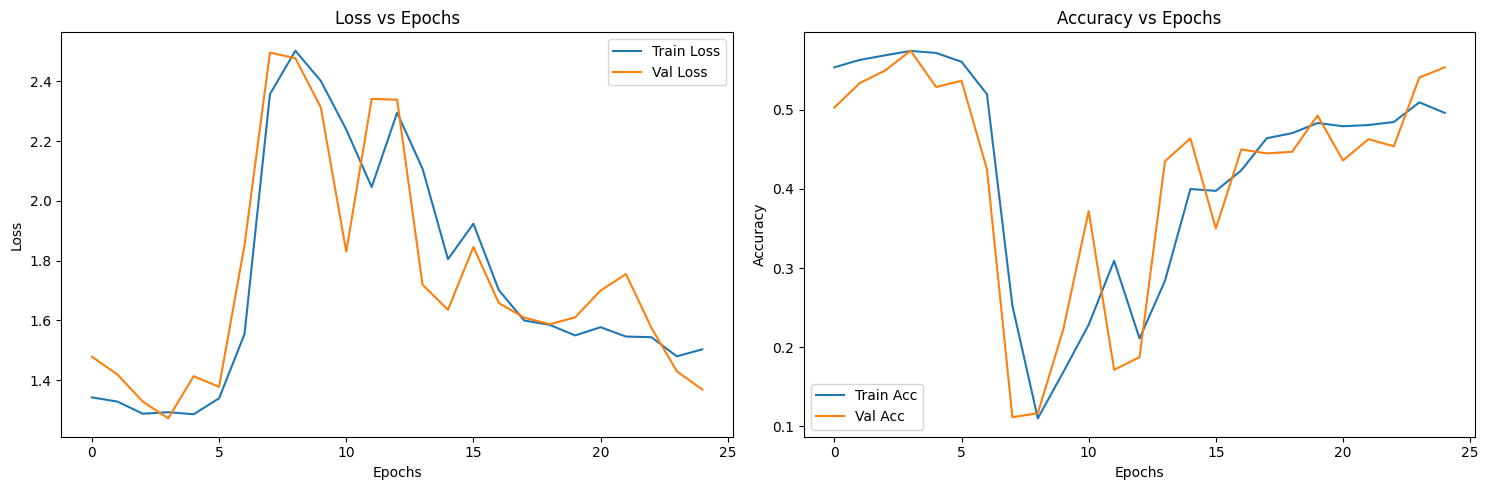

In [56]:
fig,axs=plt.subplots(1,2,figsize=(15,5))

axs[0].plot(total_loss_train_plot,label='Train Loss')
axs[0].plot(total_loss_val_plot,label='Val Loss')
axs[0].set_title("Loss vs Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

axs[1].plot(total_acc_train_plot,label='Train Acc')
axs[1].plot(total_acc_val_plot,label='Val Acc')
axs[1].set_title("Accuracy vs Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()